In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv,norm

# ============================================ Solvers ============================================

def odefe(f,h,t0,te,y0):
    '''
    f: function dependant on (tn,yn) assumed to be **vectorized**
    h: step size
    t0: start time
    te: end time
    y0: IC
        
    Returns: a dxn matrix where d is the function dimension and n is num. time steps
             a vector of times
    '''    
    n = int(np.floor((te - t0)/h)) # We expect the floor to be irrelevant in our experiments
    d = y0.size
    ysave = np.zeros((d,n))
    
    t = t0
    y = y0.copy()
    
    ysave = []
    tsave = [] 
    while t <= te:

        tsave.append(t)
        ysave.append(y)
        y = y + h * f(t,y.copy())

        t += h
    return np.array(tsave),np.array(ysave)

# Backward Euler
def odebe(f,Jf,h,t0,te,y0):
    
    '''
    f: function dependant on (tn,yn) assumed to be **vectorized**
    h: step size
    t0: start time
    te: end time
    y0: IC
        
    Returns: a dxn matrix where d is the function dimension and n is num. time steps
             a vector of times
    '''    
    def nr(t,y,f,Jf,x0,tol=10**(-6)):
        evals = 0
        F = lambda x: (x - y - h*f(t,x))
        JF = lambda x: np.eye(len(y)) - h*Jf(t,x)

        n = 0
        xk = x0
        while n < 1000:
            xk1 = xk - np.matmul(inv(JF(xk)),F(xk))
            evals += 2
            if norm(xk - xk1) < tol:
                return xk1,evals        
            xk = xk1                        
            n += 1  
        
        
    n = int(np.ceil((te - t0)/h)) 
    d = y0.size
    
    t = t0
    y = y0.copy()
    
    ysave = []
    tsave = []

    while t <= te:
        tsave.append(t)
        ysave.append(y)
        
        t += h
        x0 = y + h * f(t,y.copy())    
        y,evals = nr(t,y,f,Jf,x0)
        
        
    return np.array(tsave), np.array(ysave)

def oderk4(f,h,t0,te,y0):
    '''
    f: function dependant on (tn,yn) assumed to be **vectorized**
    h: step size
    t0: start time
    te: end time
    y0: IC
        
    Returns: a dxn matrix where d is the function dimension and n is num. time steps
             a vector of times
    '''    
    
    n = int(np.floor((te - t0)/h)) # We expect the floor to be irrelevant in our experiments
    d = y0.size
    ysave = np.zeros((d,n))
    
    t = t0
    y = y0.copy()
    
    ysave = []
    tsave = []  
    while t < te:
        tsave.append(t)
        ysave.append(y)
        
        # Update y
        k1 = f(t,y)
        k2 = f(t + h/2,y + h*k1/2)
        k3 = f(t + h/2,y + h*k2/2)
        k4 = f(t+h,y + h*k3)
        
        y = y + h*(k1 + 2*k2 + 2*k3 + k4)/6

        
        t += h
    return np.array(tsave),np.array(ysave)

def odesymeuler(f,h,t0,te,y0):

    n = int(np.floor((te - t0)/h)) # We expect the floor to be irrelevant in our experiments
    d = y0.size
    ysave = np.zeros((d,n))

    hv = h*np.ones(len(y0))
    hv[0:len(y0)//2] = 0

    hz = h*np.ones(len(y0))
    hz[len(y0)//2:] = 0

    t = t0
    y = y0.copy()

    ysave = []
    tsave = []

    while t < te:
        evals_iter = 0

        tsave.append(t)
        ysave.append(y)

        # Symplectic Euler step - I code this way so as to not need to change my other functions
        v = y.copy()
        v = v + hv * f(t,v.copy())
        y[len(y0)//2:] = v[len(y0)//2:] # get the updated velocity only
        y = y + hz * f(t,y.copy())
        
        t += h

    return np.array(tsave),np.array(ysave)

def vertlet(f,h,t0,te,x0,v0):
    # computes stormer-vertlet integration
    # expects x0 to be the initial position: v0 initial velocity
    t = t0
    ysave = []
    tsave = []
    tsave.append(t)
    ysave.append(x0)    
    
    x1 = x0 + v0*h + f(t,x0)*(h**2)/2
    t += h
    tsave.append(t)
    ysave.append(x1)
    
    xn = 2*x1 - x0 + f(t,x1)*(h**2)
    xnm1 = x1
    t += h
    tsave.append(t)
    ysave.append(xn)
    
    while t <= te:
        xnp1 = 2*xn - xnm1 + f(t,xn)*(h**2)
        t += h
        tsave.append(t)
        ysave.append(xnp1)
        
        xnm1 = xn
        xn = xnp1
        
    return np.array(tsave),np.array(ysave)    

def gautschi(ypp,g,omega,h,t0,te,q0,q1,v0,v1):    
    # ypp is the function that describes the double time derivative of position    
    # omega is the value assume to be part of the position's second derivative
    t = t0 + h   
    tsave = []
    ysave = []
    
    qnm1 = q0
    vnm1 = v0
    qn = q1
    vn = v1
            
    ysave.append([qnm1,vnm1])
    ysave.append([qn,vn])
    tsave.append(t0)
    tsave.append(t0 + h)
                
    while t <= te:
        t += h
        qnp1 = h**2 * (sinc(h*omega/2)**2)*g(t,qn,omega) + 2*np.cos(h*omega)*qn - qnm1
        vnp1 = 2*h*sinc(h*omega)*ypp(t,qn,omega) + vnm1
        
        ysave.append([qnp1,vnp1])
        tsave.append(t)
                

        qnm1 = qn
        vnm1 = vn
        qn = qnp1
        vn = vnp1


    return np.array(tsave), np.array(ysave)



# ============================================ Problems ============================================

def testODE(t,y,l = 1):
    # The test equation is y' = l*y 
    return l*y


def testOSC(t,y,omega = 1):
    # The test equation is y'' = - omega^2 * y
    
    # Split into system of first order ODEs
    z = y[1]
    y = y[0]
    
    dy = z
    dz = - omega**2 * y
    
    return np.array([dy,dz])

def jacobianOSC(t,y,omega=1):
    return np.array([[0 , 1],[-omega**2, 0]])
    
def trueOSC(t,y0,omega):
    def mat(mu):
        return np.array([[np.cos(mu),np.sin(mu)],[-np.sin(mu),np.cos(mu)]])
                        
    D = np.diag([1,omega])
    Dinv = np.linalg.inv(D)
    mu = t*omega
    phi = mat(mu)
    
    change = np.dot(np.dot(D,phi),Dinv)
    return np.matmul(change,y0)      

def testpp(t,y,omega):
    return -omega**2 * y    

def gpp(t,y,omega):
    return 0


# Motivation

To motivate the study of highly oscillatory ODEs, let's look at the *harmonic oscillator* ODE

$$
y'' = - \omega^2 y
$$

In order to solve this system, we first rewrite it as a first order ODE. Introduce the variable $z$ representing velocity. Then the system becomes

$$
y' = z \\
z' = - \omega^2 y
$$

The true solution is given by 

$$
\begin{pmatrix} y(t_0 + t) \\ z(t_0 + t) \end{pmatrix} = D M(\omega \cdot t) D^{-1} \begin{pmatrix} y_0 \\ z_0 \end{pmatrix}
$$

Where $D = diag(1,\omega)$ and 

$$
M(\cdot) = \begin{bmatrix} \cos(\cdot) & \sin(\cdot) \\ -\sin(\cdot) & \cos(\cdot) \end{bmatrix}
$$



This ODE describes harmonic oscillation. Take the motion of a spring for example. The solutions of this ODE are given by the family of sine curves $y(t) = A \sin(\omega t + \phi) $ where $\omega t + \phi$ is the phase and $A$ is the amplitude. $\omega$ is known as the pulse, and is the parameter that determines the frequency and the period of the system. The period of the system is 

$$
T = \frac{2\pi}{\omega}
$$

So the frequency is given by 

$$
f = \frac{1}{T} = \frac{\omega}{2\pi}
$$

Using classical ODE integrators, the system gets harder and harder to solve as $\omega$ increase. We shown this now by looking at the accuracy after 1 period of Forward Euler as a function of $\omega$. The step size is fixed at $h = 0.01$.

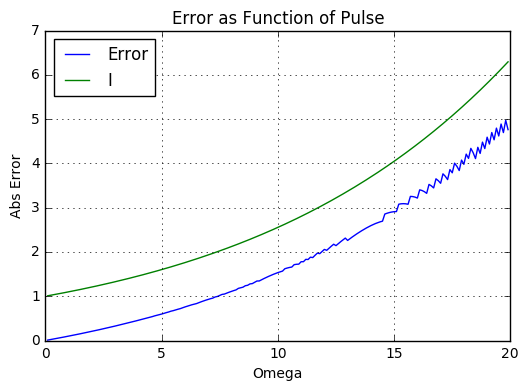

In [3]:
omegas = np.arange(0.1,20,0.1)
h = 0.01
approx = []
true = []
ns = []
for omega in omegas:
    t0 = 0
    te = 3 * (2 * np.pi / omega)
    n = (te - t0)/h
    ns.append(n)
    h = 0.01
    y0 = np.array([1,0])

    t,y = odefe(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
    true_val = trueOSC(t[-1],y0,omega)[0]

    approx.append(y[:,0][-1])
    true.append(true_val)                  
        
growth = [(1 + h**2 * w**2)**(n/2) for w,n in zip(omegas,ns)]
true = np.array(true)
approx = np.array(approx)
plt.plot(omegas,abs(true - approx))
plt.plot(omegas,growth)
plt.title('Error as Function of Pulse')
plt.ylabel('Abs Error')
plt.xlabel('Omega')
plt.legend(['Error','I'],loc = 'best')
plt.grid()
plt.show()

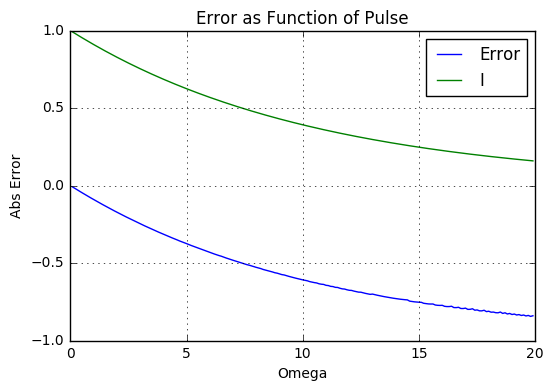

In [4]:
omegas = np.arange(0.1,20,0.1)

approx = []
true = []
ns = []
for omega in omegas:
    t0 = 0
    te = 3 * (2 * np.pi / omega)
    n = (te - t0)/h
    ns.append(n)
    h = 0.01
    y0 = np.array([1,0])

    t,y = odebe(lambda t,y: testOSC(t,y,omega),lambda t,y: jacobianOSC(t,y,omega),h,t0,te,y0)
    true_val = trueOSC(t[-1],y0,omega)[0]

    approx.append(y[:,0][-1])
    true.append(true_val)                  
        
growth = [(1 + h**2 * w**2)**(-n/2) for w,n in zip(omegas,ns)]
true = np.array(true)
approx = np.array(approx)
plt.plot(omegas,approx - true)
plt.plot(omegas,growth)
plt.title('Error as Function of Pulse')
plt.ylabel('Abs Error')
plt.xlabel('Omega')
plt.legend(['Error','I'],loc = 'best')
plt.grid()
plt.show()

But even Runge-Kutta 4 will struggle eventually. It takes a larger pulse but, there are a good deal of systems that one would want to model that have a very high frequency. 

In engineering one might want to model the frequency of pistons or springs. Physicists might want to model electrons.

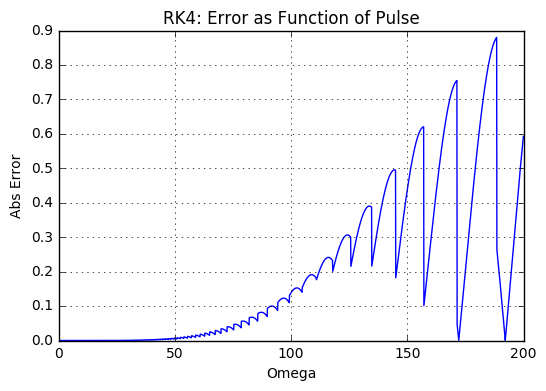

In [5]:
omegas = np.arange(0.1,200,0.1)

approx = []
true = []
for omega in omegas:
    t0 = 0
    te = 3 * (2 * np.pi / omega)
    h = 0.01
    y0 = np.array([1,0])

    t,y = oderk4(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
    true_val = trueOSC(t[-1],y0,omega)[0]

    approx.append(y[:,0][-1])
    true.append(true_val)                  
            
true = np.array(true)
approx = np.array(approx)
plt.plot(omegas,abs(true - approx))
plt.title('RK4: Error as Function of Pulse')
plt.ylabel('Abs Error')
plt.xlabel('Omega')
plt.grid()
plt.show()



# Problems with classical methods

We'll look at forward and backward Euler methods for a case study. These methods showcase the kinds of problems that arise when trying to solve oscillatory systems.

In [6]:
omega = 1
t0 = 0
te = 20
h = 0.1
y0 = np.array([1,0])

tfe,yfe = odefe(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
tse,yse = odesymeuler(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
tbe,ybe = odebe(lambda t,y: testOSC(t,y,omega),lambda t,y: jacobianOSC(t,y,omega),h,t0,te,y0)
time = np.linspace(t0,te,100)
true = np.array([trueOSC(t,y0,omega)[0] for t in time ])


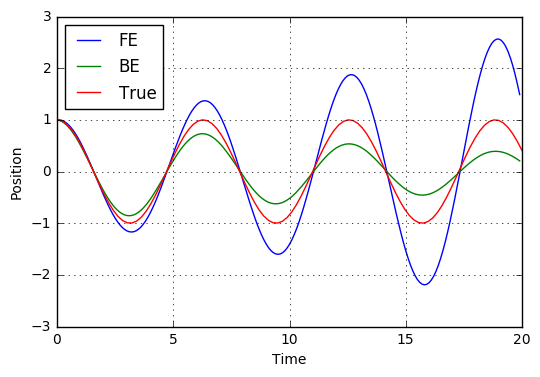

In [7]:
plt.plot(tfe,yfe[:,0])
plt.plot(tbe,ybe[:,0])
#plt.plot(tse,yse[:,0]) # Maybe don't include in the plot
plt.plot(time,true)

plt.legend(['FE','BE','True'],loc = 'upper left')
plt.ylabel('Position')
plt.xlabel('Time')
plt.grid()
plt.show()

Here is the fundamental issue with these problems. The explicit methods *increase* the amount of energy in the system. The *explicit* methods decrease the amount of energy in the system. 

The fundamental reason for this is that both ***do not respect the geometry of the system***.

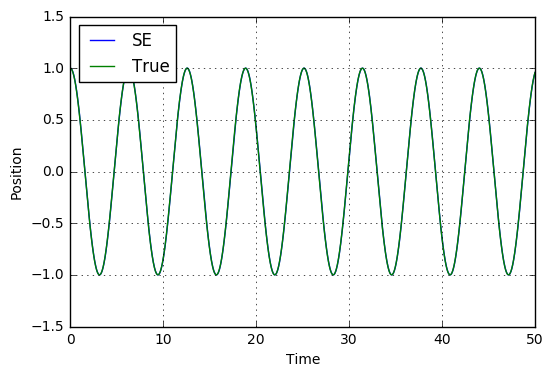

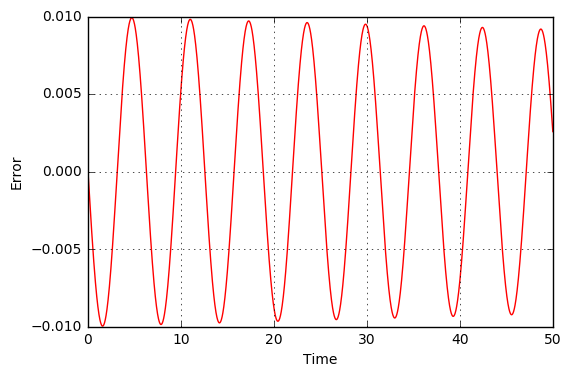

In [8]:
omega = 1
t0 = 0
te = 50
h = 0.02
y0 = np.array([1,0])

time = np.linspace(t0,te,1000)
tse,yse = odesymeuler(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
true = np.array([trueOSC(t,y0,omega)[0] for t in tse ])


plt.plot(tse,yse[:,0]) 
plt.plot(tse,true)
plt.ylabel('Position')
plt.xlabel('Time')
plt.legend(['SE','True'],loc='best')
plt.grid()
plt.show()


plt.plot(tse,true - yse[:,0],color = 'red')
plt.ylabel('Error')
plt.xlabel('Time')
plt.grid()
plt.show()

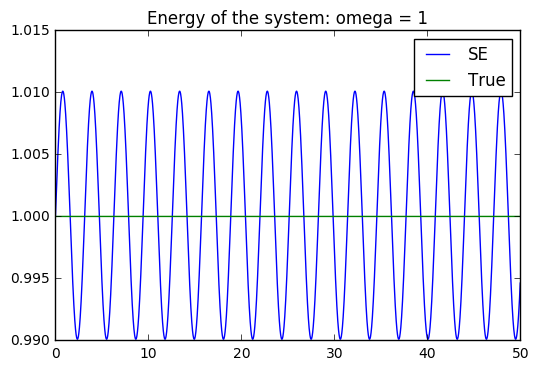

In [9]:
# Plot the energy of symplectic Euler over time

plt.plot(tse,yse[:,1]**2 + omega**2 * yse[:,0]**2) # Large h still has bounded energy but no longer has total energy near the true level (which is omega**2)
true = np.array([trueOSC(t,y0,omega) for t in tse ])
plt.plot(tse,true[:,1]**2 + omega**2 * true[:,0]**2)
plt.title('Energy of the system: omega = 1')
plt.legend(['SE','True'],loc='best')
plt.show()

But, this would not be considered *highly* oscillatory. So what happens it $\omega$ is increased so that 

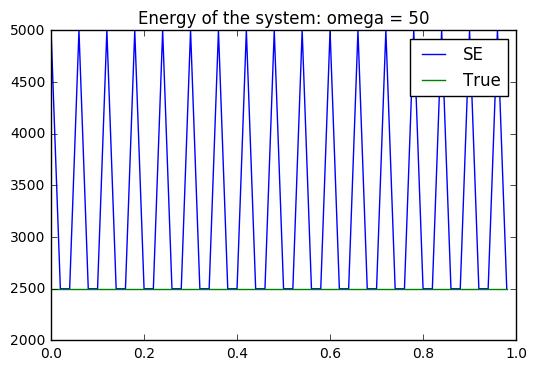

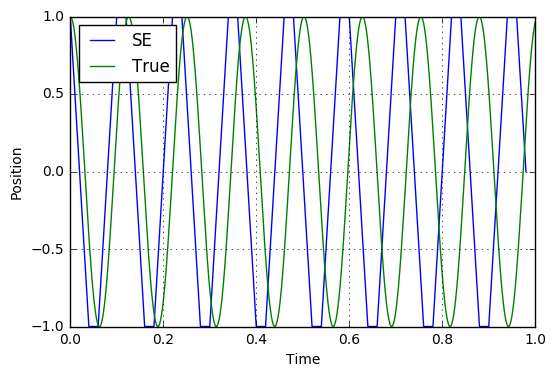

In [10]:
omega = 50
t0 = 0
te = 1
h = 0.02
y0 = np.array([1,0])

time = np.linspace(t0,te,1000)
tse,yse = odesymeuler(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
true = np.array([trueOSC(t,y0,omega)[0] for t in tse ])

plt.plot(tse,yse[:,1]**2 + omega**2 * yse[:,0]**2) # Large h still has bounded energy but no longer has total energy near the true level (which is omega**2)
true = np.array([trueOSC(t,y0,omega) for t in tse ])
plt.plot(tse,true[:,1]**2 + omega**2 * true[:,0]**2)
plt.title('Energy of the system: omega = '+ str(omega))
plt.legend(['SE','True'],loc='best')
plt.show()


true = np.array([trueOSC(t,y0,omega) for t in time])
plt.plot(tse,yse[:,0]) 
plt.plot(time,true[:,0])
plt.ylabel('Position')
plt.xlabel('Time')
plt.legend(['SE','True'],loc='best')
plt.grid()
plt.show()

# Stormer-Vertlet

The most popular method for modelling molecular dynamics. It is versatile and in general has nice behaviour.

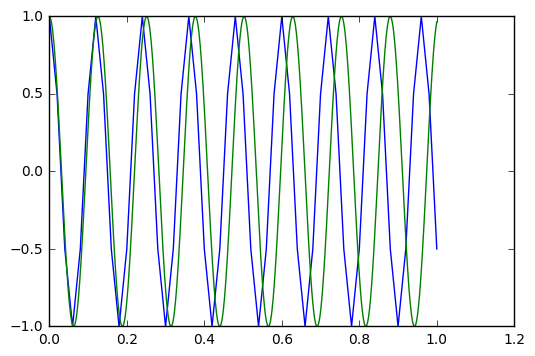

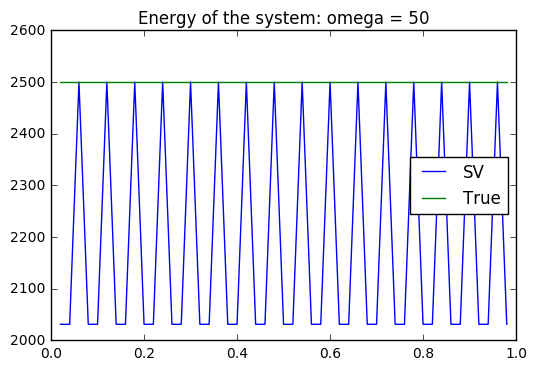

In [11]:
omega = 50
y0 = np.array([1,0])
h = 0.02 # nice value is 0.03
t0 = 0
te = 1

#t,y = odefe(lambda t,y: testOSC(t,y,omega),h,t0,t0 + h,y0)
x0 = trueOSC(t0,y0,omega)[0]
v0 = trueOSC(t0,y0,omega)[1]/omega
time = np.linspace(t0,te,1000)
tv,yv = vertlet(lambda t,y: testpp(t,y,omega),h,t0,te,x0,v0)
true = np.array([trueOSC(t,y0,omega)[0] for t in time])

plt.plot(tv,yv)
plt.plot(time,true)
plt.show()


# Calculate velocities
vv = []
for i in range(1,len(yv)-1):
    v = (yv[i+1] - yv[i-1])/ (2*h)
    vv.append(v)

vv = np.array(vv)


plt.plot(tv[1:-1],vv**2 + omega**2 * yv[1:-1]**2) # Large h still has bounded energy but no longer has total energy near the true level (which is omega**2)
true = np.array([trueOSC(t,y0,omega) for t in tv[1:-1]])
plt.plot(tv[1:-1],true[:,1]**2 + omega**2 * true[:,0]**2)
plt.title('Energy of the system: omega = '+ str(omega))
plt.legend(['SV','True'],loc='best')
plt.show()

So it seems that the Stormer-Vertlet model works pretty well. Let's see how the energy conservation of the system is.

# Energy (Dis)-Conservation of Classical Methods

First let's look at FE.

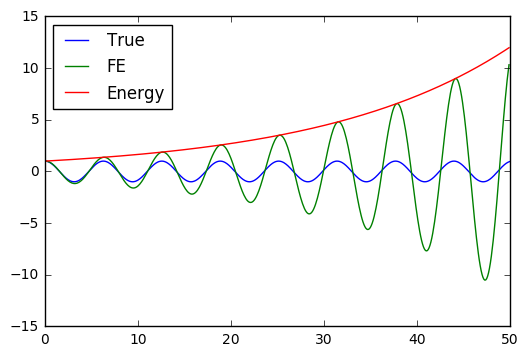

In [12]:
omega = 1
t0 = 0
te = 50
h = 0.1
y0 = np.array([1,0])
time = np.linspace(t0,te,1000)

# Calculate values
true = np.array([trueOSC(t,y0,omega)[0] for t in time ])
tfe,yfe = odefe(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
growth = [(1+ h**2 * omega**2)**(n/2) for n,elem in enumerate(tfe)]

plt.plot(time,true)
plt.plot(tfe,yfe[:,0])
plt.plot(tfe,growth)
plt.legend(['True','FE','Energy'],loc = 'best')
plt.show()

We see that explicit Euler increases the amount of energy in the system. This leads to increased amplitude oscillations even when they do not exist.

Now let's explore implicit Euler.

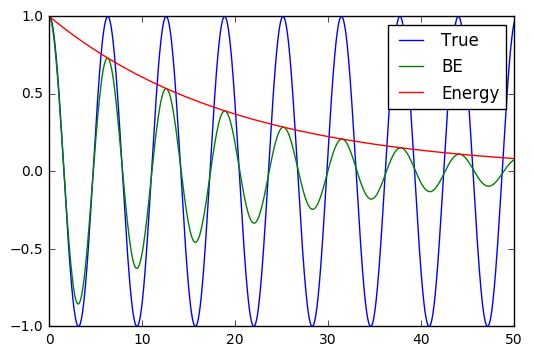

In [13]:
omega = 1
t0 = 0
te = 50
h = 0.1
y0 = np.array([1,0])
time = np.linspace(t0,te,1000)

# Calculate values
true = np.array([trueOSC(t,y0,omega)[0] for t in time ])
tbe,ybe = odebe(lambda t,y: testOSC(t,y,omega),lambda t,y: jacobianOSC(t,y,omega),h,t0,te,y0)
growth = [(1+ h**2 * omega**2)**(-n/2) for n,elem in enumerate(tbe)]

plt.plot(time,true)
plt.plot(tfe,ybe[:,0])
plt.plot(tfe,growth)

plt.legend(['True','BE','Energy'],loc = 'best')
plt.show()

Although, the Euler methods are able to track the period of the system they do not conserve energy. It should be noted that these methods would probably not even be considered *highly* oscillatory. The methods have a pulse $\omega=1$ and thus a period of $2\pi$. This is hardly a very fast oscillation.

Just for fun, let's see what happens with a *somewhat* fast oscillation. 

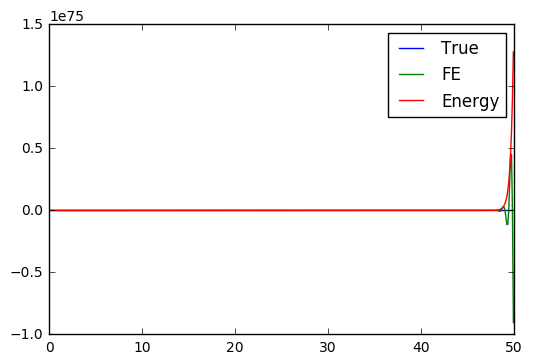

In [14]:
omega = 10
t0 = 0
te = 50
h = 0.1
y0 = np.array([1,0])
time = np.linspace(t0,te,1000)

# Calculate values
true = np.array([trueOSC(t,y0,omega)[0] for t in time ])
tfe,yfe = odefe(lambda t,y: testOSC(t,y,omega),h,t0,te,y0)
growth = [(1+ h**2 * omega**2)**(n/2) for n,elem in enumerate(tfe)]

plt.plot(time,true)
plt.plot(tfe,yfe[:,0])
plt.plot(tfe,growth)
plt.legend(['True','FE','Energy'],loc = 'best')
plt.show()

Cleary, the method does not perform very well.

# Gautschi's Trigonometric Method

The method is meant to be used on problems of the form

$$
\ddot{y} = -\omega^2 y + g(y)
$$

Our test problem is exactly of this form with $g(y) = 0$. We expect this method to be exact whenever $g = const$. The method is a multistep method given by 

$$
y_{n+1} - 2y_n + y_{n-1} = \frac{4}{\omega^2} \sin^2 \left (\frac{h \omega}{2} \right) \ddot{y_n}
$$

# Gautschi Allows Large h

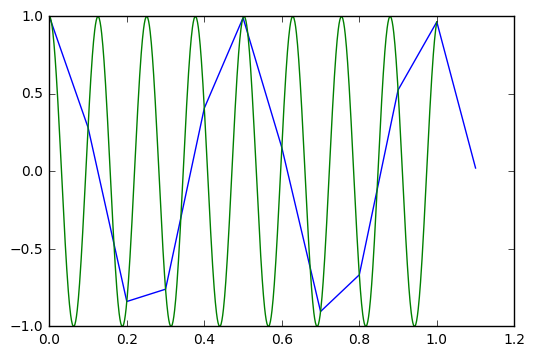

In [31]:
omega = 50
y0 = np.array([1,0])
h = 0.1
t0 = 0
te = 1

q0 = trueOSC(t0,y0,omega)[0]
q1 = trueOSC(t0+h,y0,omega)[0]
v0 = trueOSC(t0,y0,omega)[1]
v1 = trueOSC(t0+h,y0,omega)[1]

time = np.linspace(t0,te,1000)
tg,yg = gautschi(testpp,gpp,omega,h,t0,te,q0,q1,v0,v1)
true = np.array([trueOSC(t,y0,omega) for t in time])

plt.plot(tg,yg[:,0])
plt.plot(time,true[:,0])
plt.show()

In [16]:
omega = 500
y0 = np.array([1,0])
h = 0.5
t0 = 0
te = 1000

t,y = odefe(lambda t,y: testOSC(t,y,omega),h,t0,t0 + h,y0)
q0 = trueOSC(t0,y0,omega)[0]
q1 = trueOSC(t0+h,y0,omega)[0]
v0 = trueOSC(t0,y0,omega)[1]
v1 = trueOSC(t0+h,y0,omega)[1]

time = np.linspace(t0,te,1000)
tg,yg = gautschi(testpp,gpp,omega,h,t0,te,q0,q1,v0,v1)
true = np.array([trueOSC(t,y0,omega) for t in tg])

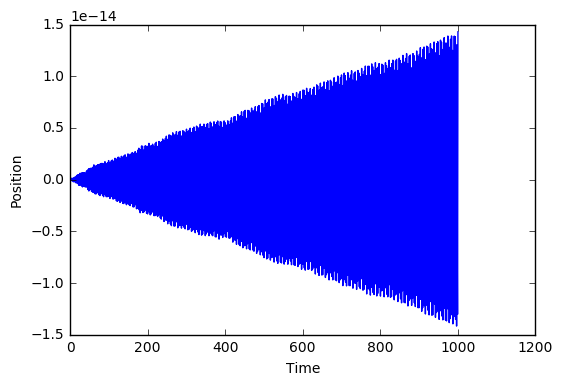

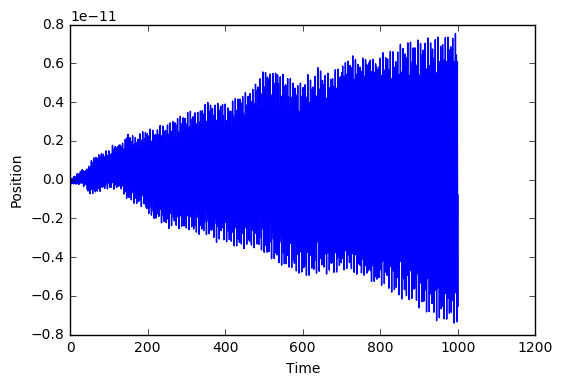

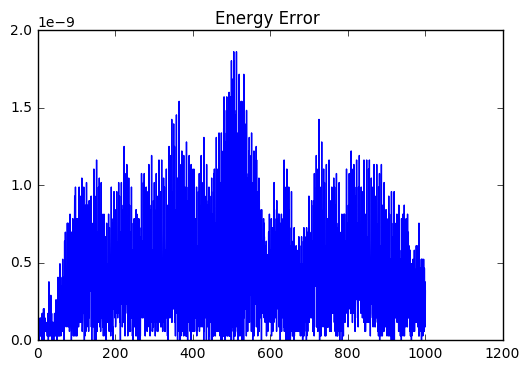

In [17]:
plt.plot(tg,yg[:,0] - true[:,0])
#plt.plot(time,true)
plt.ylabel('Position')
plt.xlabel('Time')
#plt.plot(tg,true)
plt.show()


plt.plot(tg,yg[:,1] - true[:,1])
#plt.plot(time,true)
plt.ylabel('Position')
plt.xlabel('Time')
#plt.plot(tg,true)
plt.show()


energy_yg = yg[:,1]**2 + omega**2 * yg[:,0]**2
energy_true = true[:,1]**2 + omega**2 * true[:,0]**2

plt.plot(tg,abs(energy_yg - energy_true)) # Large h still has bounded energy but no longer has total energy near the true level (which is omega**2)
true = np.array([trueOSC(t,y0,omega) for t in tg])
#plt.plot(tg,energy_true)
plt.title('Energy Error ')
plt.show()

# Error of Gautschi's Method as function of omega

In [54]:
omegas = range(5,1000,5)
y0 = np.array([1,0])
h = 0.1
t0 = 0
te = 100

q0 = trueOSC(t0,y0,omega)[0]
q1 = trueOSC(t0+h,y0,omega)[0]
v0 = trueOSC(t0,y0,omega)[1]
v1 = trueOSC(t0+h,y0,omega)[1]

    
final_err = []
for omega in omegas:
    q0 = trueOSC(t0,y0,omega)[0]
    q1 = trueOSC(t0+h,y0,omega)[0]
    tg,yg = gautschi(testpp,gpp,omega,h,t0,te,q0,q1,v0,v1)    
    true = trueOSC(tg[-1],y0,omega)[0]    
    final_err.append(yg[-1] - true)

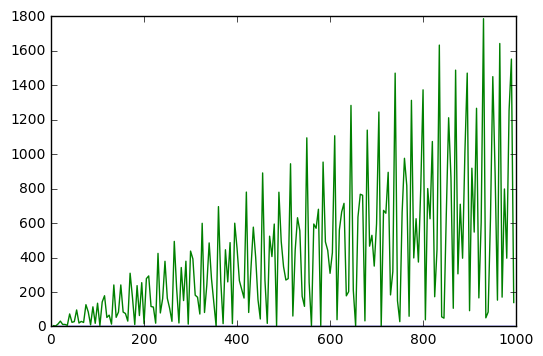

In [55]:
final_err = np.array(final_err)
plt.plot(omegas,abs(final_err))
plt.show()

In [ ]:
def hairer(ypp,omega,h,t0,te,q0,q1):    
    # ypp is the function that describes the double time derivative of position    
    # omega is the value assume to be part of the position's second derivative
    t = t0 + h   
    tsave = []
    ysave = []
    
    qnm1 = q0
    qn = q1    
        
    ysave.append(qnm1)
    ysave.append(qn)
    tsave.append(t0)
    tsave.append(t0 + h)
                
    while t <= te:
        t += h
        qnp1 = h**2 * (sinc(h*omega)**2)*ypp(t,qn,omega) + 2*qn - qnm1        
        ysave.append(qnp1)
        tsave.append(t)
                

        qnm1 = qn
        qn = qnp1    


    return np.array(tsave), np.array(ysave)

In [28]:
omegas = range(5,1000,5)
y0 = np.array([1,0])
h = 0.1
t0 = 0
te = 100


final_err = []
for omega in omegas:
    q0 = trueOSC(t0,y0,omega)[0]
    q1 = trueOSC(t0+h,y0,omega)[0]
    tg,yg = hairer(testpp,omega,h,t0,te,q0,q1)    
    true = trueOSC(tg[-1],y0,omega)[0]    
    final_err.append(yg[-1] - true)

NameError: name 'hairer' is not defined

In [ ]:
final_err = np.array(final_err)
omegas = np.array(omegas)
plt.plot(omegas*h,abs(final_err))
plt.show()

# Testing Gautchi as function of h omega

In [63]:
omegas = range(50,710,5)

energy_error = []
for omega in omegas:
    y0 = np.array([1,0])
    h = 0.02
    t0 = 0
    te = 1000

    t,y = odefe(lambda t,y: testOSC(t,y,omega),h,t0,t0 + h,y0)
    q0 = trueOSC(t0,y0,omega)[0]
    q1 = trueOSC(t0+h,y0,omega)[0]
    v0 = trueOSC(t0,y0,omega)[1]
    v1 = trueOSC(t0+h,y0,omega)[1]

    time = np.linspace(t0,te,1000)
    tg,yg = gautschi(testpp,gpp,omega,h,t0,te,q0,q1,v0,v1)
    true = np.array([trueOSC(t,y0,omega) for t in tg])
    energy_yg = yg[:,1]**2 + omega**2 * yg[:,0]**2
    energy_true = true[:,1]**2 + omega**2 * true[:,0]**2
    
    diff = abs((energy_yg - energy_true) / energy_true)
    energy_error.append(np.max(diff))
    
    
    

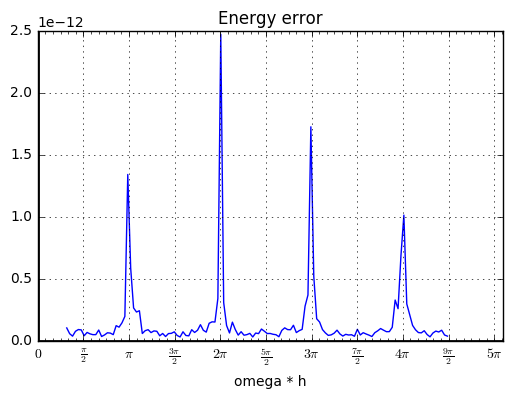

In [64]:
omegas = np.array(omegas)
energy_error = np.array(energy_error)


plt.plot(omegas*h,energy_error)
plt.title('Energy error')
plt.xlabel('omega * h')
ax = plt.gca()
ax.grid(True)
ax.axhline(0, color='black', lw=2)
ax.axvline(0, color='black', lw=2)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
plt.show()

In [59]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator

In [48]:
def nonling(t,y):
    return np.cos(3.3*t)

def nonlintestpp(t,y,omega):
    return -omega**2*y + nonling(t,y,omega)

def sinc(x):
    # sinc = sin(x)/x : a convenience function
    return np.sin(x)/x

def nonlinOSC(t,y,omega = 1):
    # The test equation is y'' = - omega^2 * y
    
    # Split into system of first order ODEs
    z = y[1]
    y = y[0]
    
    dy = z
    dz = nonlintestpp(t,y,omega)
    
    return np.array([dy,dz])


def truenonlinOSC(t,y0,w,wf,c1,c2):
    y = c1*np.cos(w*t) + c2*np.sin(w*t) + np.cos(wf*t)/(wf**2 -w**2)
    v = -c1*w*np.sin(w*t) + c2*w*np.cos(w*t) - wf*np.sin(wf*t)/(wf**2 -w**2)
    
    return np.array([y,v])   



In [50]:

omega = 3
y0 = np.array([0,0])
h = 0.001
t0 = 0
te = 20

c1 = -1 / (3.3**2 - omega**2)
c2 = 0


q0 = trueOSC(t0,y0,omega)[0]
q1 = trueOSC(t0+h,y0,omega)[0]
v0 = trueOSC(t0,y0,omega)[1]
v1 = trueOSC(t0+h,y0,omega)[1]

time = np.linspace(t0,te,1000)


tg,yg = gautschi(nonlintestpp,nonling,omega,h,t0,te,q0,q1,v0,v1)
true = np.array([truenonlinOSC(t,y0,omega,3.3,c1,c2) for t in tg])


plt.plot(tg,-true[:,0])
#plt.plot(trk,yrk[:,0])
plt.plot(tg,yg[:,0])
plt.ylabel('Position')
plt.xlabel('time')
plt.legend(['TR','G'])
#plt.ylim([-1,1.1])
#plt.plot(time,true[:,0])
plt.show()

TypeError: nonling() takes 2 positional arguments but 3 were given

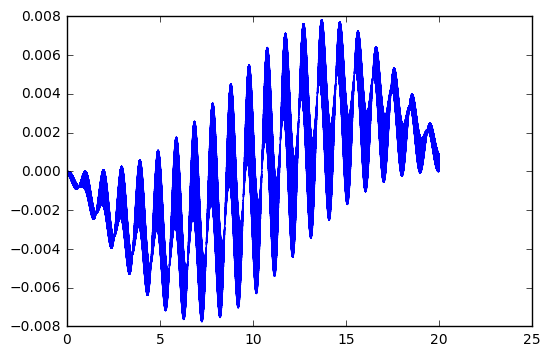

In [47]:
true = -true
energy_true = true[:,1]**2 + omega**2 * true[:,0]**2
energy_yg = yg[:,1]**2 + omega**2 * yg[:,0]**2


plt.plot(tg,energy_yg - energy_true)
#plt.plot(tg,energy_true)
#plt.plot(tg,ycos)
plt.show()

In [242]:
g(1,2,3)

-0.9899924966004454

0.3076923076923077
